# Trajectory inference for hematopoiesis in mouse

Reconstructing myeloid and erythroid differentiation for data of [Paul et al. (2015)](http://doi.org/10.1016/j.cell.2015.11.013).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc
import utils as ut
import glob
from sklearn.metrics import classification_report

In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()
sc.settings.set_figure_params(dpi=300, frameon=False, figsize=(3, 3), facecolor='white')  # low dpi (dots per inch) yields small inline figures

In [3]:
# List all files in the directoty
h5ad_list = glob.glob("saved/adata/review/*.h5ad")

In [4]:
h5ad_list[3].split("1214")[0].split("\\")[1]

'GSE117872_HN137'

In [5]:
h5ad_list[0].split("\\")

['saved/adata/review',
 'GSE1108941214data_GSE110894_drug_I.BET.762_bottle_128_edim_512,256_pdim_256,128_model_DAE_dropout_0.1_gene_T_lr_0.01_mod_new_sam_downsampling.h5ad']

In [70]:
f= h5ad_list[0]
adata = sc.read_h5ad(filename=f)
adata.X.shape

(1419, 6644)

In [8]:
h5ad_list = [h5ad_list[-1]]

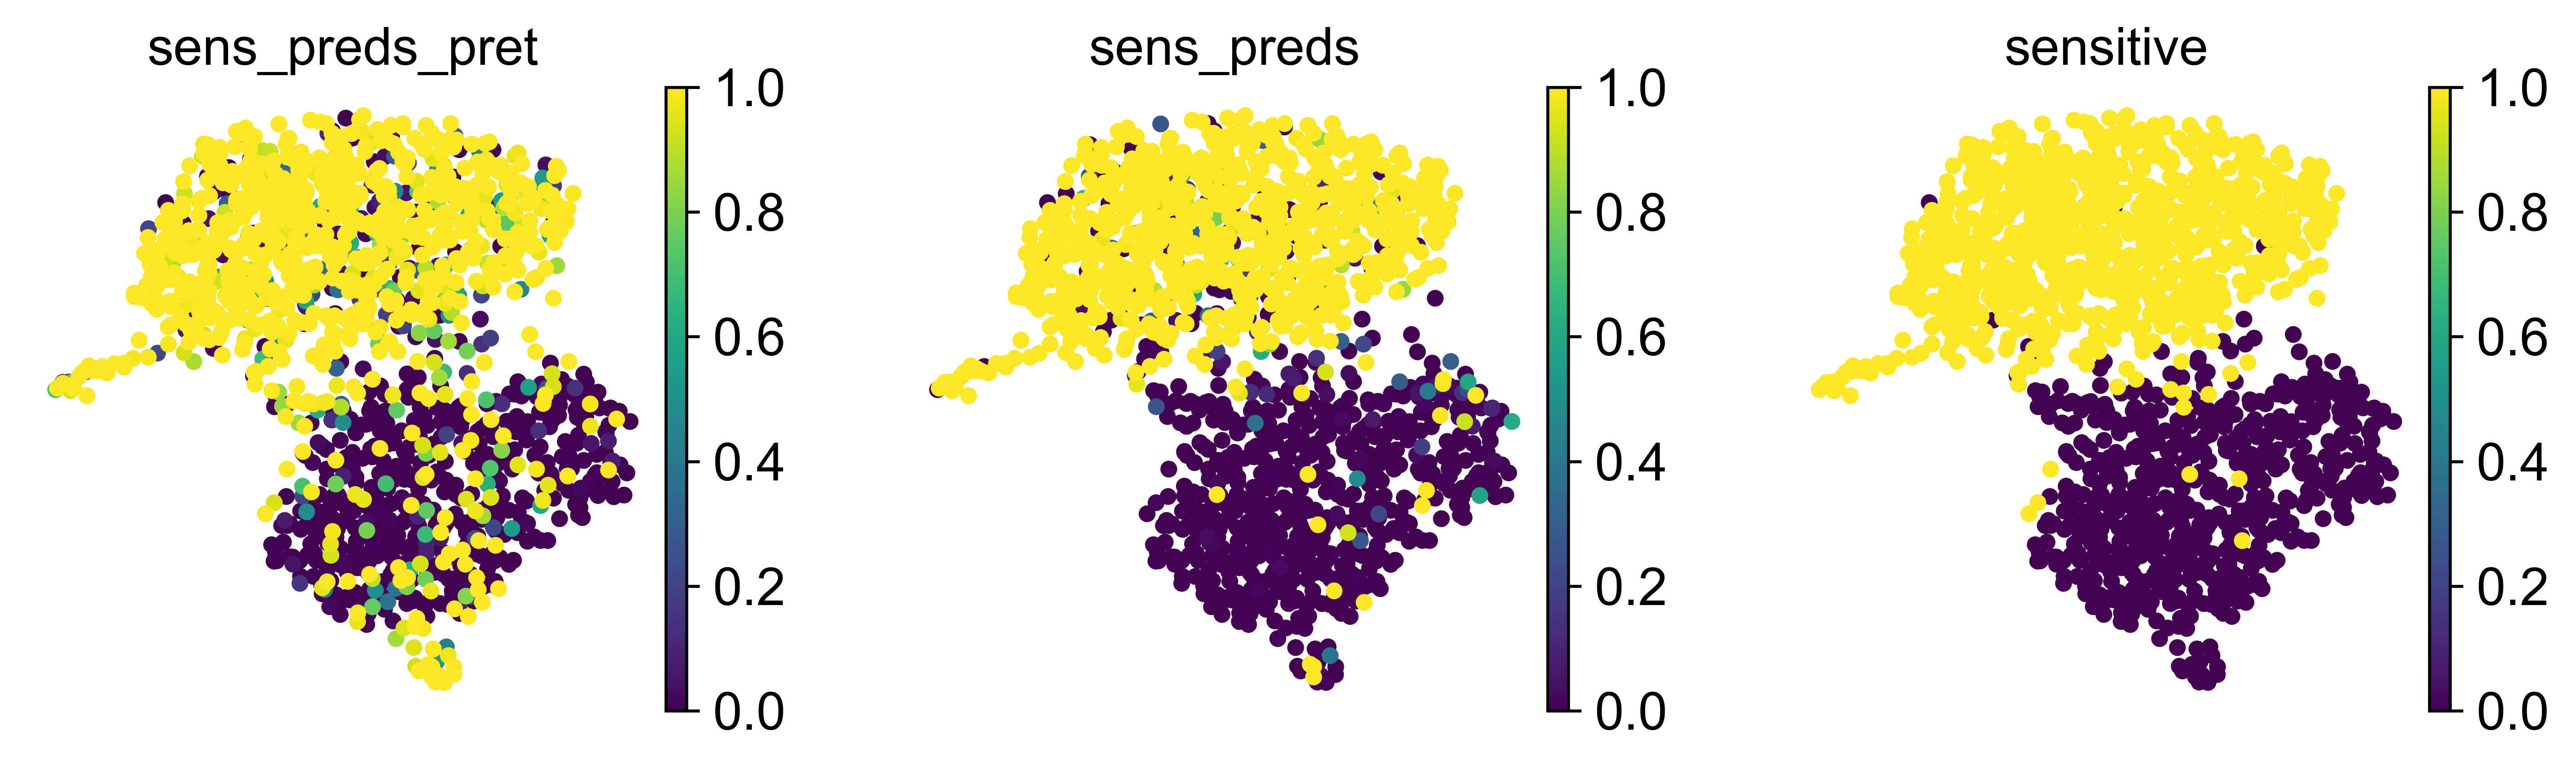

In [9]:
from sklearn.metrics import (auc, average_precision_score,
                             classification_report, mean_squared_error,
                             precision_recall_curve, r2_score, roc_auc_score)

names = []
score = []
model = []

for f in h5ad_list:
    adata = sc.read_h5ad(filename=f)
    pretrain_label = adata.obs['sens_label_pret']
    sens_label = adata.obs['sens_label']

    grouth_truth = adata.obs['sensitive']
    sens_pb_pret = adata.obs['sens_preds_pret']
    sens_label_pret = adata.obs['sens_label_pret']
    sens_pb = adata.obs['sens_preds']

    name = f.split("1214")[0].split("\\")[1]
    
    
    report_dict_pret = classification_report(grouth_truth, pretrain_label, output_dict=True)
    classification_report_pret_df = pd.DataFrame(report_dict_pret).T
    f1score_pret = report_dict_pret['weighted avg']['f1-score']
    ap_pret = average_precision_score(grouth_truth, sens_pb_pret)
    auroc_pret = roc_auc_score(grouth_truth, sens_label_pret)

    
    report_dict = classification_report(grouth_truth, sens_label, output_dict=True)
    classification_report_df = pd.DataFrame(report_dict).T
    f1score = report_dict['weighted avg']['f1-score']
    ap = average_precision_score(grouth_truth, sens_pb)
    auroc = roc_auc_score(grouth_truth, sens_label)
    
    names.append(name)
    score.append(f1score_pret)
    model.append("before")
    
    names.append(name)
    score.append(f1score)
    model.append("transfer")

    result = pd.DataFrame({"f1":[f1score_pret,f1score],
                          "ap":[ap_pret,ap],
                          "auroc":[auroc_pret,auroc]},index=["pretrain","transfer"])
    
    print()
    sc.pl.umap(adata,color=['sens_preds_pret','sens_preds','sensitive'],save="report_compare"+name + '.png')
    
    result.to_csv("saved/results/report_compare"+name + '.csv')



In [10]:
result_compare = pd.DataFrame({"data":names,
                      "transfer":model,
                      "score":score})

In [16]:
adata

AnnData object with n_obs × n_vars = 1496 × 7234
    obs: 'sensitive', 'sensitivity', 'Resistant_score', 'Sensitive_score', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt-', 'pct_counts_mt-', 'total_counts_rps', 'pct_counts_rps', 'total_counts_rpl', 'pct_counts_rpl', 'leiden', 'leiden_origin', 'sens_preds_pret', 'sens_label_pret', 'sens_preds', 'sens_label', 'rest_preds'
    var: 'n_cells', 'mt-', 'rps', 'rpl', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'neighbors', 'pca', 'rank_genes_groups', 'umap', 'leiden_colors'
    obsm: 'X_pca', 'X_pre', 'X_umap', 'X_umap_origin'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [11]:
result_compare

data  transfer     score
0  GSE149383    before  0.823453
1  GSE149383  transfer  0.906310

[None, None]

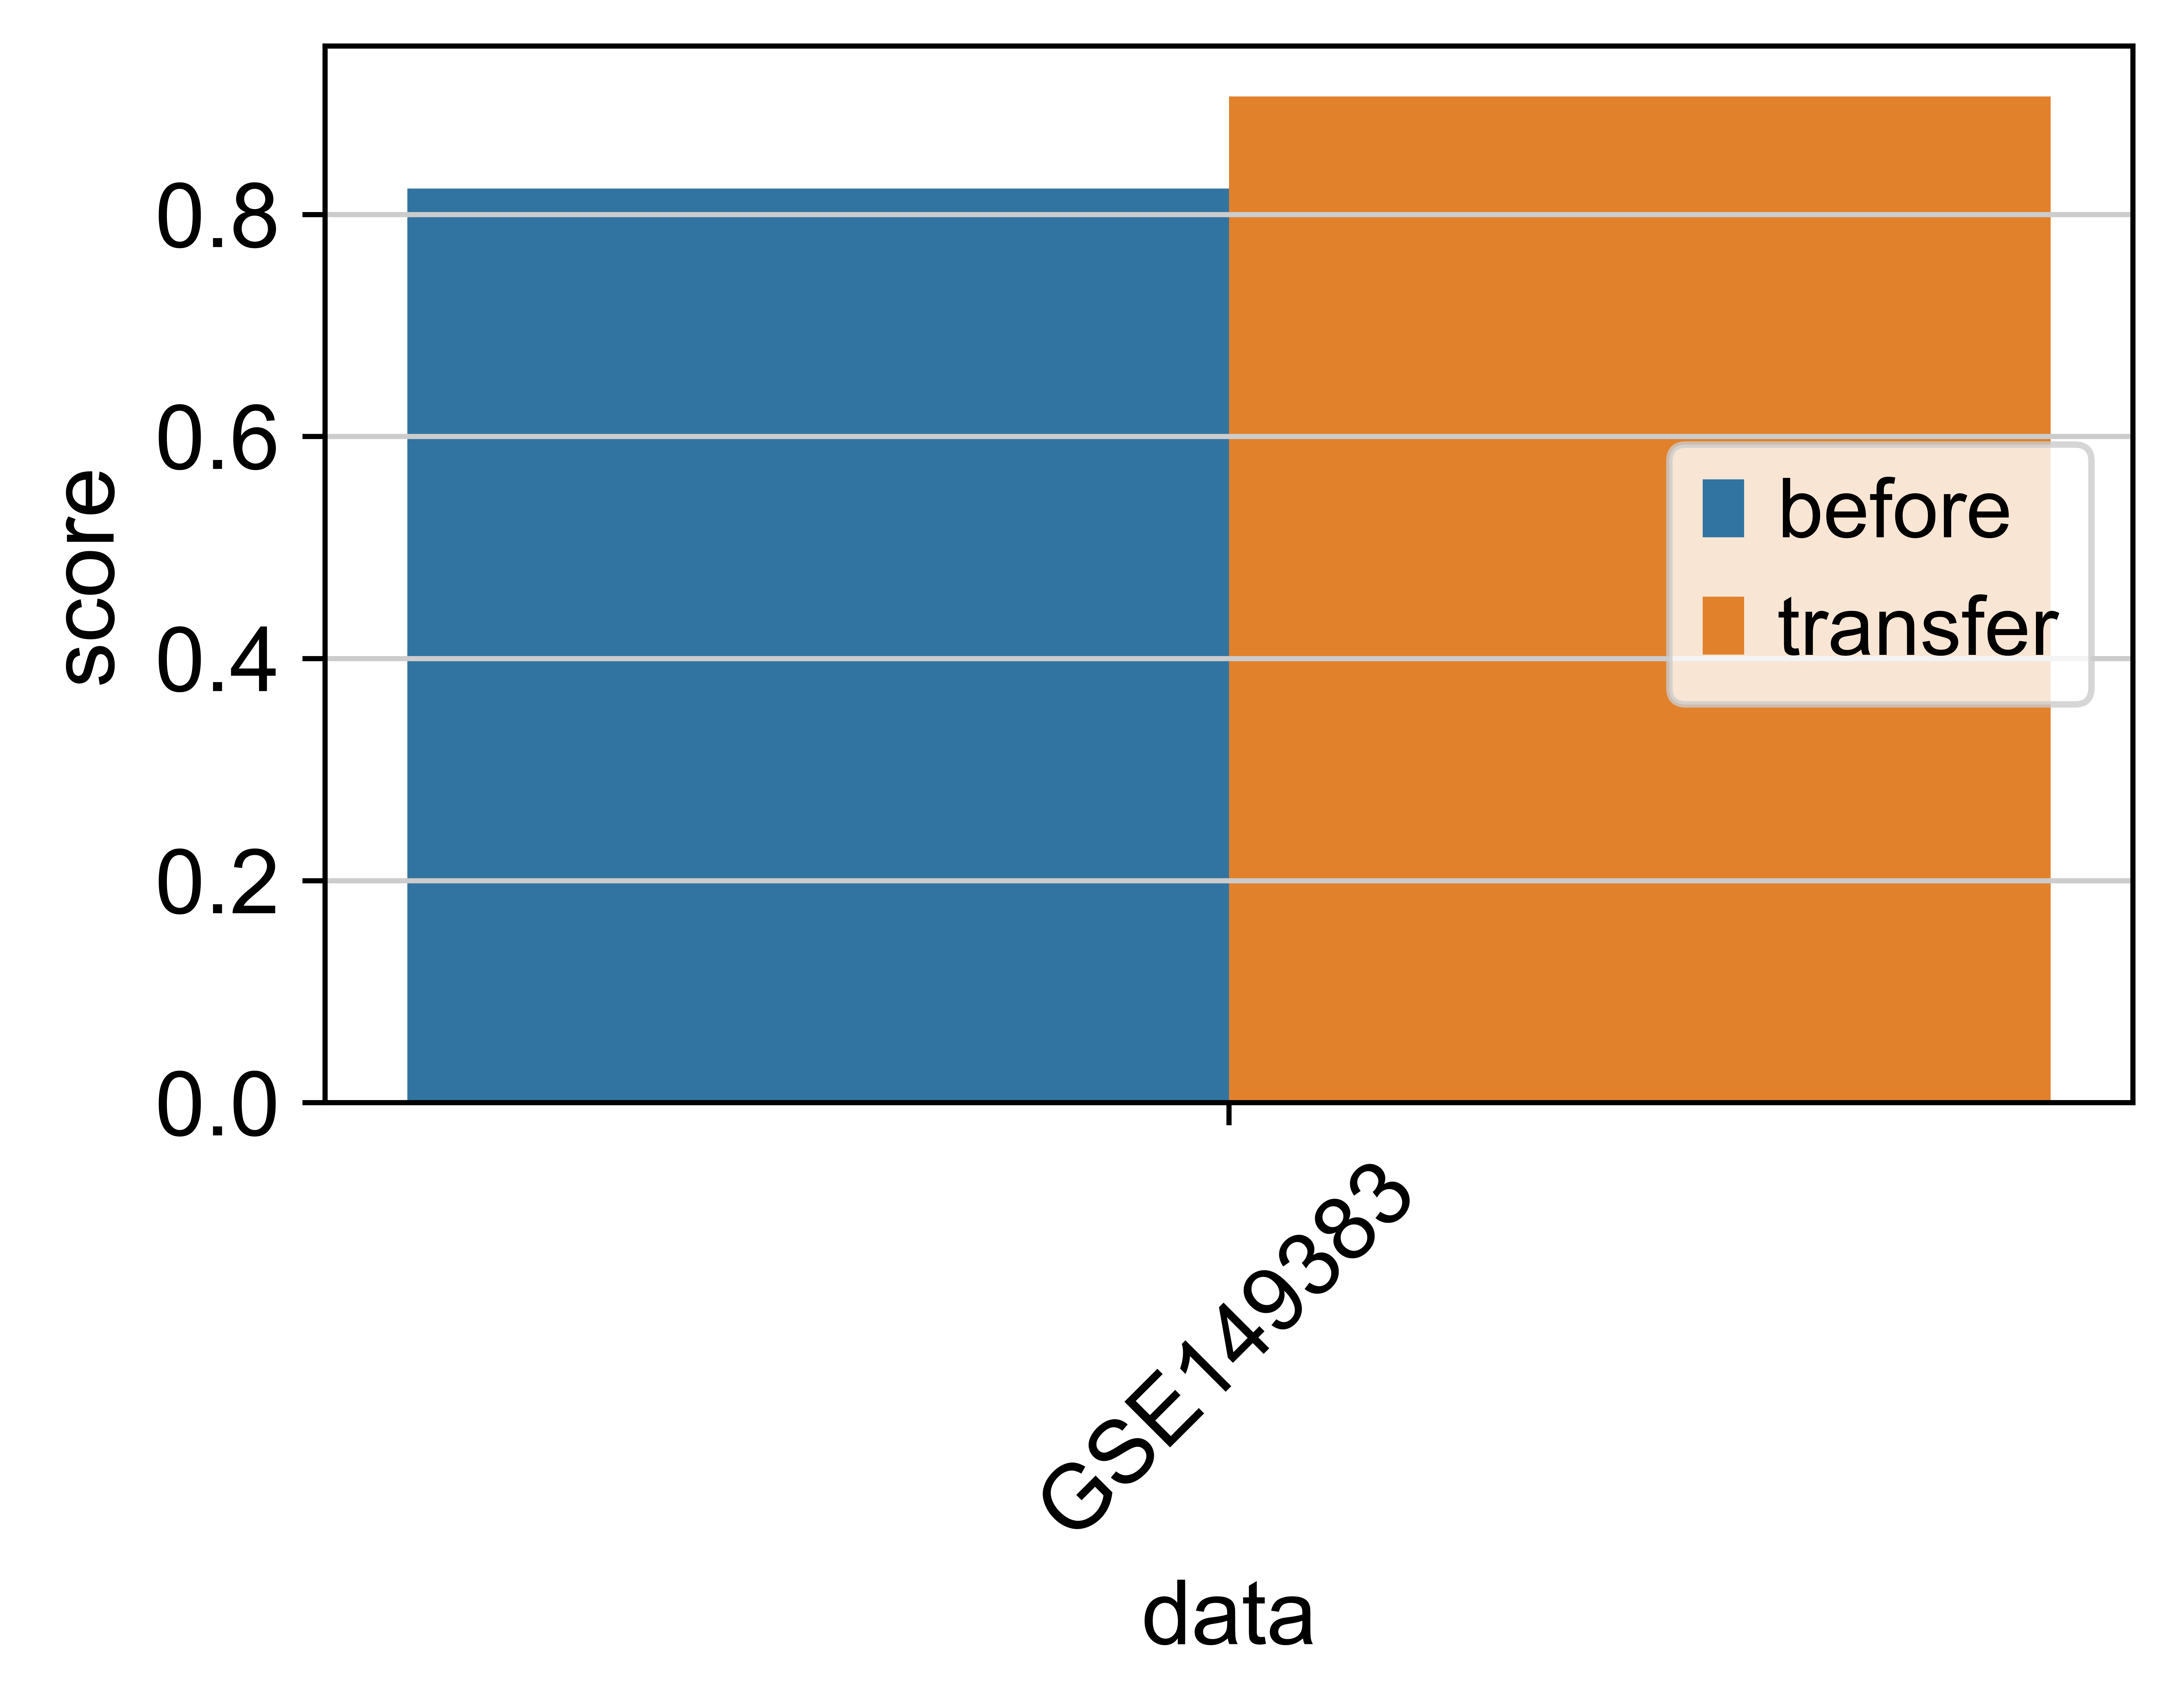

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sc.settings.set_figure_params(dpi=800, frameon=False, figsize=(5, 3), facecolor='white')  # low dpi (dots per inch) yields small inline figures
g = sns.barplot(x="data", y="score",hue="transfer",
                data=result_compare)
plt.legend(loc='right')

plt.setp(g.get_xticklabels(), rotation=45)

In [13]:
sc.pl.umap(adata,color=['sensitive','leiden'])